In [ ]:
#@title Get Loaded into the Pipeline
try:
    from boxsdk import OAuth2, Client
except ImportError:
    %pip install boxsdk --quiet
    from boxsdk import OAuth2, Client
import os, time, shutil
from google.colab import drive
import pandas as pd
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
from IPython.display import clear_output, Audio, display
from scipy.signal import spectrogram
from google.colab import drive
import os, random, librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
class BoxNavigator():
    def __init__(self) -> 'None':
        drive.mount('/content/drive/', force_remount=True)
        self.home_dir = '/content/drive/MyDrive/manacus2/'
        system_files_dir = os.path.join(self.home_dir, 'system files')
        if not os.path.exists(system_files_dir):
            self.setup_credentials()
        else:
            self.load_credentials_from_file()

        if not os.path.exists(self.home_dir):
            os.makedirs(self.home_dir)
            print(f"New folder made: {self.home_dir}.")

    def load_credentials_from_file(self) -> 'None':
        credentials_file_path = os.path.join(self.home_dir, 'system files', 'box_credentials.txt')
        with open(credentials_file_path, 'r') as file:
            lines = file.readlines()
            self.client_id = lines[0].strip()
            self.client_secret = lines[1].strip()
            self.access_token = lines[2].strip()

        self.auth = OAuth2(client_id=self.client_id, client_secret=self.client_secret, access_token=self.access_token)
        self.client = Client(self.auth)

    def setup_credentials(self) -> 'None':
        print("Login to https://tulane.app.box.com/developers/console and paste the following:")
        self.client_id = input("Enter your Box Client ID: ")
        self.client_secret = input("Enter your Box Client Secret: ")
        self.access_token = input("Enter your Box Developer Token: ")
        sys_files_path = os.path.join(self.home_dir, 'system files')
        os.makedirs(sys_files_path)
        os.mkdir(os.path.join(self.home_dir, 'Downloaded Videos'))
        credentials_file_path = os.path.join(sys_files_path, 'box_credentials.txt')
        with open(credentials_file_path, 'w') as file:
            file.write(f"{self.client_id}\n{self.client_secret}\n{self.access_token}")

        self.auth = OAuth2(client_id=self.client_id, client_secret=self.client_secret, access_token=self.access_token)
        self.client = Client(self.auth)

    def search(self, video_name: str):
      try:
        return next(iter(self.client.search().query(query=video_name, limit=1)))
      except:
        self.access_token = input("Enter your Box Developer Token: ")
        sys_files_path = os.path.join(self.home_dir, 'system files')
        credentials_file_path = os.path.join(sys_files_path, 'box_credentials.txt')
        with open(credentials_file_path, 'w') as file:
            file.write(f"{self.client_id}\n{self.client_secret}\n{self.access_token}")
        self.auth = OAuth2(client_id=self.client_id, client_secret=self.client_secret, access_token=self.access_token)
        self.client = Client(self.auth)
        return self.search(video_name)

    def download_vid(self, video_name: str) -> None:
        assert os.path.exists(os.path.join(self.home_dir, 'Downloaded Videos'))
        video_path = os.path.join(self.home_dir, 'Downloaded Videos', video_name)
        if os.path.exists(video_path):
            print(f"Video '{video_name}' already exists in Drive.")

        else:
            video_item_returned = self.search(video_name)
            if video_item_returned.name == video_name and video_item_returned.type == 'file' and video_name.lower().endswith("mp4"):
                print(f"Downloading video '{video_name}' to Drive: {video_path}...")
                with open(video_path, 'wb') as f:
                    self.client.file(video_item_returned.id).download_to(f)
                print(f"    Successfully saved video '{video_name}' from Box in Drive.")
            else:
                print(f"    Video '{video_name}' not found in Box or is not an mp4 file.")

    def extract_audio_clips(self, video_name):
        videos_folder_path = os.path.join(self.home_dir, 'Downloaded Videos')
        video_path = os.path.join(videos_folder_path, video_name)
        video_files = [f for f in [video_name] if os.path.isfile(video_path) and (f.lower().endswith(".mp4") or f.lower().endswith(".avi"))]

        for video_file in video_files:
            video_path = os.path.join(videos_folder_path, video_file)

            try:
                # Create directory for audio clips of this video
                video_name_without_ext = os.path.splitext(video_file)[0]
                audio_clips_folder_path = os.path.join(videos_folder_path, video_name_without_ext)

                if not os.path.exists(audio_clips_folder_path):
                    os.makedirs(audio_clips_folder_path)
                    video_clip = VideoFileClip(video_path)
                    audio_clip = video_clip.audio

                    audio_clip_duration = int(audio_clip.duration)  # Duration in seconds

                    i = 0
                    while i < audio_clip_duration:
                        start_time = i
                        end_time = i + 0.5
                        subclip = audio_clip.subclip(start_time, end_time)

                        # Extract audio subclip and save
                        clip_filename = f"{video_name_without_ext}_{int(i*2):04d}.wav"
                        clip_filepath = os.path.join(audio_clips_folder_path, clip_filename)

                        if not os.path.exists(clip_filepath):
                            subclip.write_audiofile(clip_filepath, codec='pcm_s16le')
                            print(f"Saved clip: {clip_filename}")

                        i += 0.5

                    video_clip.reader.close()
                    audio_clip.reader.close_proc()

            except IOError as e:
                print(f"An error occurred for {video_file}: {e}")

    def labelclips(self, video_name):
        # Check if labels folders exist, if not, create them
        labels_dir = os.path.join(self.home_dir, 'labels')
        labels = ['s', 'g', 'c', 'r', 'w', 'n', 'q']  # Define your labels here
        label_dirs = [os.path.join(labels_dir, label) for label in labels]
        for label_dir in label_dirs:
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)

        # Get the directory that contains the audio clips
        audio_clips_dir = os.path.join(self.home_dir, 'Downloaded Videos', os.path.splitext(video_name)[0])
        if os.path.exists(audio_clips_dir):
            audio_clips = [clip for clip in os.listdir(audio_clips_dir) if clip.lower().endswith(".wav")]
            n_clips = len(audio_clips)
            for audio_clip in audio_clips:
                n_clips-=1
                clear_output()
                # Play audio clip
                clip_path = os.path.join(audio_clips_dir, audio_clip)
                print(f"Playing {audio_clip}")
                display(Audio(clip_path, autoplay=True))
                time.sleep(1)

                # Ask for the user input for labeling
                label = ''
                print(f"{n_clips} clips remaining.")
                while label not in labels:
                    label = input("Enter label (s, g, c, r, w, n, q):\n").lower().strip()
                # Move the audio clip to the corresponding label directory
                destination_path = os.path.join(labels_dir, label, audio_clip)
                shutil.move(clip_path, destination_path)
                print(f"Moved {audio_clip} to {destination_path}")
        else:
            print(f"There are no audio clips extracted for the video {video_name}.")


def labeled_sounds_2(labeled_sounds_folder):
  drive.mount("/content/drive/", force_remount=True)
  labeled_sound_folders = [os.path.join(labeled_sounds_folder, f) for f in os.listdir(labeled_sounds_folder) if f[0] != '.']
  labeled_sounds_dict = {}
  for f in labeled_sound_folders:
    category = os.path.basename(f)
    all_files = [os.path.join(f, file_name) for file_name in os.listdir(f)]
    labeled_sounds_dict[category] = all_files

  # balance the data before processing
  balanced_dict = balance_sounds(labeled_sounds_dict)
  #balanced_dict = labeled_sounds_dict

  sound_signature_dict = {}
  for sound in balanced_dict.keys():
    print(f"processing {len(balanced_dict[sound])} samples <-- {len(labeled_sounds_dict[sound])} total {sound} files")
    sound_signature_dict[sound] = []
    for sound_example in balanced_dict[sound]:
      """y, sr = librosa.load(random_grunt_file, mono=True)
      y_downsampled = abs(y)
      y_downsampled = smooth_list(y_downsampled, 50)
      target_sr = sr // 5  # Target sampling rate (e.g., 1/5th of the original)
      y_downsampled = librosa.resample(np.array(y_downsampled), orig_sr=sr, target_sr=target_sr)
      y_downsampled = minmax_norm(y_downsampled)"""

      y, sr = librosa.load(sound_example, mono=True)
      D = librosa.stft(y, n_fft=200, hop_length=5)
      D_t = np.transpose(D)
      div_factor = 10
      D_t_downsampled = [D_t[i] for i in range(0, len(D_t), div_factor)]
      D_t_reshaped = abs(np.transpose(D_t_downsampled))
      D_t_reshaped = np.array([np.interp(row, (row.min(), row.max()), (-1, 1)) for row in D_t_reshaped])
      D_t_reshaped = np.transpose(D_t_reshaped)
      D_t_reshaped = np.array([np.interp(row, (row.min(), row.max()), (-1, 1)) for row in D_t_reshaped])
      D_t_reshaped = np.transpose(D_t_reshaped)[:60]
      """y, sr = librosa.load(sound_example, mono=True)
      y = np.array([y[i] for i in range(0, len(y), 2)])
      f, t, Sxx = spectrogram(y, fs=sr, nperseg=100, noverlap=88)"""
      sound_signature_dict[sound].append([D_t_reshaped, sound_example])

  return sound_signature_dict


def smooth_list(lst, window_size):
  return [sum(lst[i:i+window_size])/window_size for i in range(len(lst)-window_size+1)]

def minmax_norm(x):
    x = np.array(x)  # Ensure x is a NumPy array
    upper_thresh = np.mean(x) + 10 * np.std(x)
    x[x > upper_thresh] = upper_thresh
    return (x - np.min(x)) / (np.max(x) - np.min(x))


nav = BoxNavigator()
print('Please upload a spreadsheet to My Drive/manacus2/spreadsheets/')

labels_dir = '/content/drive/My Drive/manacus2/labels/'
labels = [os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if os.path.basename(f)[0] != '.']
total = []
for f in labels:
  for i in os.listdir(f):
    total.append('_'.join(i.split('_')[:-1]))
total = set(total)
print(total)
print(len(total), 'videos have been anotated')

sheets_folder = '/content/drive/My Drive/manacus2/spreadsheets/'
os.makedirs(sheets_folder, exist_ok=True)
sheet_paths = os.listdir(sheets_folder)
while len(sheet_paths) == 0:
  drive.mount('/content/drive/', force_remount=True)
  sheet_paths = os.listdir(sheets_folder)
  input('Have you uploaded a spreadsheet to My Drive/manacus2/spreadsheets/? (Y/N)')

sheet_path = sheet_paths[3]
print(f'using {sheet_path}')
spreadsheet = pd.read_excel(os.path.join(sheets_folder, sheet_path))
if not 'FileName' in spreadsheet.columns:
  spreadsheet.columns = spreadsheet.iloc[0]
  spreadsheet = spreadsheet.iloc[1:]
spreadsheet = spreadsheet[(spreadsheet['FileName'].str.contains('L')) & (spreadsheet['FileName'].str.contains('.P'))]
#downloaded_videos = os.listdir(os.path.join(nav.home_dir, 'Downloaded Videos'))
#spreadsheet = spreadsheet[~spreadsheet['FileName'].isin(downloaded_videos)]
labeling_for = 'Snaps'
#spreadsheet = spreadsheet[pd.to_numeric(spreadsheet[labeling_for], errors='coerce').notna()]
#spreadsheet = spreadsheet.sort_values(by=labeling_for, ascending=False).reset_index(drop=True)
spreadsheet = spreadsheet.sample(frac=1).reset_index(drop=True)
label_paths = [os.path.join(nav.home_dir, 'labels', f) for f in os.listdir(os.path.join(nav.home_dir, 'labels')) if f[0] != '.']
for label_path in label_paths:
  print(label_path.split('/')[-1], len(os.listdir(label_path)))
print('total clips:', sum([len(os.listdir(label_path)) for label_path in label_paths]))

Mounted at /content/drive/
Please upload a spreadsheet to My Drive/manacus2/spreadsheets/
{'L6.P2_7.12.22-8.3.22_0113', 'LC.P5_1.13.22-1.19.22_0001', 'L14.P2_08.02.22-08.17.22_0015', 'L14.P2_08.02.22-08.17.22_0009', 'L14.P2_08.02.22-08.17.22_0115', 'L6.P2_7.12.22-8.3.22_0224', 'LC.P4_12.28.21-1.13.22_0075', 'L6.P5_08.07.23-08.13.23_0114', 'LM.P2_12.18.21-12.26.21_0215', 'L6.P5_08.07.23-08.13.23_0123', 'L14.P2_08.02.22-08.17.22_0215', 'L6.P1_07.29.23-08.04.23 (PRE-EXPERIMENT WEEK)_0087', 'L6.P8B_08.05.23-08.11.23_0014', 'L14.P2_08.02.22-08.17.22_0191', 'L14.P2_08.02.22-08.17.22_0141', 'L6.P6_08.10.23-08.16.23_0472', 'LC.P3_12.5.21-12.18.21_0044', 'LC.P5_1.13.22-1.19.22_0007', 'L6.P6_08.10.23-08.16.23_x0010', 'L8.P3_12.18.21-12.28.21_0069', 'L14.P2_08.02.22-08.17.22_0082', 'L6.P2_6.10.22-6.23.22_0118', 'L6.P1_07.29.23-08.04.23 (PRE-EXPERIMENT WEEK)_0195', 'L6.P5_08.07.23-08.13.23_0191', 'L6.P5_08.07.23-08.13.23_0098', 'L14.P2_08.02.22-08.17.22_0061', 'L6.P4C_08.13.23-08.19.23_0296', 'L8.

In [ ]:
#@title Preprocessing

def spect(wav_filepath):
    y, sr = librosa.load(wav_filepath, mono=True)
    y_res = 100
    D = librosa.stft(y, n_fft=y_res*2-1, hop_length=32)
    magnitude = np.abs(D)
    log_magnitude = librosa.amplitude_to_db(magnitude)
    log_magnitude_normalized = (log_magnitude - np.mean(log_magnitude)) / np.std(log_magnitude)
    return log_magnitude_normalized

def balance_sounds(labeled_sounds_dict):
  # First, determine the number of examples in the smallest class
  min_examples = min(len(files) for files in labeled_sounds_dict.values())

  # Then, create a balanced dictionary where each class has 'min_examples' number of examples
  balanced_dict = {}
  for sound_key, files in labeled_sounds_dict.items():
    random.shuffle(files)
    if sound_key in ['n']:
      extent = 3
      class_size = (len(files) + ((extent)*min_examples))//(extent+1)
    elif sound_key in ['s']:
      extent = 1
      class_size = (len(files) + ((extent)*min_examples))//(extent+1)
    else:
      class_size = len(files)

    balanced_dict[sound_key] = files[:class_size]

  return balanced_dict

def labeled_sounds(labeled_sounds_folder):
  drive.mount("/content/drive/", force_remount=True)
  labeled_sound_folders = [os.path.join(labeled_sounds_folder, f) for f in os.listdir(labeled_sounds_folder) if f[0] != '.']
  labeled_sounds_dict = {}
  for f in labeled_sound_folders:
    category = os.path.basename(f)
    all_files = [os.path.join(f, file_name) for file_name in os.listdir(f)]
    labeled_sounds_dict[category] = all_files

  # balance the data before processing
  balanced_dict = balance_sounds(labeled_sounds_dict)

  #todo: progress printing
  sound_signature_dict = {}
  for sound in balanced_dict.keys():
    print(sound)
    sound_signature_dict[sound] = []

    for sound_example in balanced_dict[sound]:
      activity = spect(sound_example)
      sound_signature_dict[sound].append([activity, sound_example])

  return sound_signature_dict

labeled_sounds_folder = '/content/drive/MyDrive/manacus2/labels/'
sound_signature_dict = labeled_sounds_2(labeled_sounds_folder)

Mounted at /content/drive/
processing 1334 samples <-- 1334 total g files
processing 1601 samples <-- 2583 total s files
processing 2090 samples <-- 6503 total n files
processing 1062 samples <-- 1062 total w files
processing 619 samples <-- 619 total c files


In [ ]:
#@title Audio Model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling1D, LSTM, TimeDistributed
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np

# Convert lists to numpy arrays
X = []
y = []
audio_paths = []
for label, values in sound_signature_dict.items():
    for audio_spectrogram, audio_path in values:
        X.append(audio_spectrogram)
        y.append(label)
        audio_paths.append(audio_path)

X = np.array(X)
X = X.reshape(*X.shape, 1)
y = np.array(y)

# Convert the labels to categorical format
label_to_index_map = {label: index for index, label in enumerate(set(y))}
index_to_label_map = {index: label for label, index in label_to_index_map.items()}
y = tf.keras.utils.to_categorical([label_to_index_map[label] for label in y])

X_train, X_test, y_train, y_test, train_paths, test_paths = train_test_split(X, y, audio_paths, test_size=0.25, random_state=34)

# Remove the last dimension
X_train = np.squeeze(X_train, axis=-1)
X_test = np.squeeze(X_test, axis=-1)

print(X_train.shape)

num_outputs = len(label_to_index_map)

# Build the model with adjustments
def build_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=X_train[0].shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(32, activation="relu", kernel_regularizer=l2(0.02))))
    model.add(LSTM(units=32, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
    #optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

model = build_model()

model.summary()

# Path to save the best model
best_model_filepath = '/content/best_audiomodel.keras'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=best_model_filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Increase batch size & epochs for better learning
# Now, you can fit your model again
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=256,
                    callbacks=[checkpoint])

# Load the best model
best_model = tf.keras.models.load_model(best_model_filepath)

# Making predictions with the best model
prediction_results = {"correct": [], "incorrect": []}

predictions = best_model.predict(X_test)
predicted_labels = predictions.argmax(axis=1)
probabilities = predictions.max(axis=1)  # Maximum probability for each prediction
true_labels = y_test.argmax(axis=1)

for prediction, probability, true_label, audio_path in zip(predicted_labels, probabilities, true_labels, test_paths):
    predicted_label = index_to_label_map[prediction]
    true_label_str = index_to_label_map[true_label]

    if prediction == true_label:
        prediction_results["correct"].append([audio_path, true_label_str, predicted_label, probability])
    else:
        prediction_results["incorrect"].append([audio_path, true_label_str, predicted_label, probability])

# Calculate accuracy as before
accuracy = round(100 * len(prediction_results['correct']) / (len(prediction_results['incorrect']) + len(prediction_results['correct'])), 2)

# Print results
print(f"Total Predictions: {len(test_paths)}")
print(f"Correct Predictions: {len(prediction_results['correct'])}")
print(f"Incorrect Predictions: {len(prediction_results['incorrect'])}")
print(f"Accuracy: {accuracy}")

(5029, 60, 221)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 128)           179200    
                                                                 
 batch_normalization_36 (Ba  (None, 60, 128)           512       
 tchNormalization)                                               
                                                                 
 dropout_36 (Dropout)        (None, 60, 128)           0         
                                                                 
 time_distributed_18 (TimeD  (None, 60, 32)            4128      
 istributed)                                                     
                                                                 
 lstm_37 (LSTM)              (None, 32)                8320      
                                                                 
 batch_normalization_37 (Ba  (None, 3

KeyboardInterrupt: 

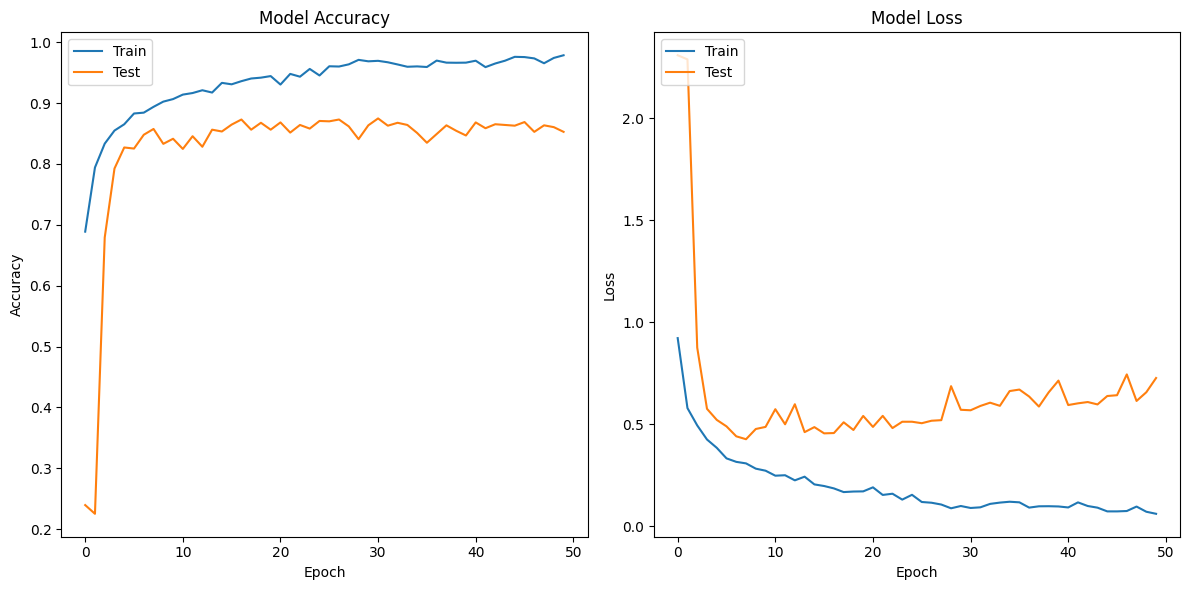

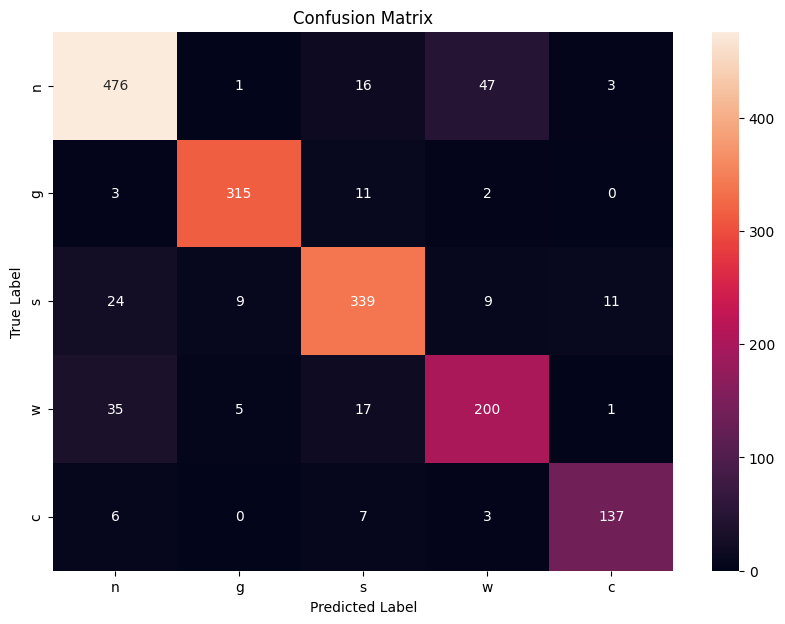

In [ ]:
#@title visualize model entrainment
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Updated prediction processing for confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Convert raw predictions (probabilities) to class indices
predicted_labels = predictions.argmax(axis=1)

# Confusion matrix in a DataFrame
df_cm = pd.DataFrame(confusion_matrix(true_labels, predicted_labels), index=[index_to_label_map[i] for i in range(num_outputs)], columns=[index_to_label_map[i] for i in range(num_outputs)])

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()